# Mecánica Celeste
## Profesor Jorge Zuluaga

### Exploración numérica: movimiento en un sistema rotante



In [41]:
!pip install -q pymcel plotly

Importación de librerias

In [42]:
import pymcel as pc
from astroquery.jplhorizons import Horizons
import spiceypy as spy
from astropy import constants as c
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


Constantes

In [43]:
au = c.au.value
day = 86400

# Unidades canónicas
UL = au
UM = c.M_sun.value + c.M_earth.value
UT = np.sqrt(UL**3/(c.G.value*UM))
UV = UL/UT

# Parametros del problema en unidades canónicas
M_moon = 7.349e22 # Kg
mu1 = c.M_sun.value/UM  # mu del sol 
mu2 = (c.M_earth.value + M_moon)/UM  # mu Sistema tierra-luna 

# Periodo de las dos partículas mayores
P = 365.25*day/UT
omega = 2*np.pi/P

# Vector omega
omega_vec = np.array([0,0,omega])

Recuperamos las posiciones de los 3 cuerpos y las convertimos en unidades canónicas:

In [44]:
epochs = dict(start='2023-10-05 00:00:00',stop='2024-10-05 00:00:00',step='1d')

jwst = Horizons(id='JWST',location='@10',epochs=epochs).vectors().to_pandas()
rjwst = np.array(jwst[['x','y','z']])*au/UL
vjwst = np.array(jwst[['vx','vy','vz']])*au/day/UV

sun = Horizons(id='10',location='@10',epochs=epochs).vectors().to_pandas()
rsun = np.array(sun[['x','y','z']])*au/UL
vsun = np.array(sun[['vx','vy','vz']])*au/day/UV

earth = Horizons(id='3',location='@10',epochs=epochs).vectors().to_pandas()
rearth = np.array(earth[['x','y','z']])*au/UL
vearth = np.array(earth[['vx','vy','vz']])*au/day/UV


Construimos las matrices de rotación para cada tiempo usando el ángulo que forman la Tierra y el Sol en el espacio:

In [45]:
# Número de puntos
Nt = len(earth)

# Inicializamos las matrices de rotación
Ms = np.zeros((Nt,3,3))

# Barremos en todas las posiciones
for i in range(Nt):
  # Vector tierra sol que definirá el ángulo
  r_earth_sun = rearth[i] - rsun[i]

  # Calculamos el ángulo usando tan(teta) = y/x
  teta = np.arctan2(r_earth_sun[1],r_earth_sun[0])

  # Matriz de rotación
  Ms[i] = spy.rotate(teta,3)

Rotamos las posiciones y las velocidades:

In [46]:
rearth_rot = np.zeros_like(rearth)
vearth_rot = np.zeros_like(rearth)

rsun_rot = np.zeros_like(rsun)
vsun_rot = np.zeros_like(vsun)

rjwst_rot = np.zeros_like(rjwst)
vjwst_rot = np.zeros_like(vjwst)

for i in range(len(earth)):
  # Posiciones rotadas
  rearth_rot[i] = spy.mxv(Ms[i],list(rearth[i]))
  rsun_rot[i] = spy.mxv(Ms[i],list(rsun[i]))
  rjwst_rot[i] = spy.mxv(Ms[i],list(rjwst[i]))

  # Formula para la velocidad: v = v' + w x r', despejando da v' = v - w x r
  vearth_rot[i] = spy.mxv(Ms[i],vearth[i]-np.cross(omega_vec,rearth[i]))
  vjwst_rot[i] = spy.mxv(Ms[i],vjwst[i]-np.cross(omega_vec,rjwst[i]))
  vsun_rot[i] = spy.mxv(Ms[i],vsun[i]-np.cross(omega_vec,rsun[i]))

Graficamos las posiciones:

(-0.05139749785339064,
 1.0793474549212034,
 -0.005759758946346882,
 0.005733335512321624)

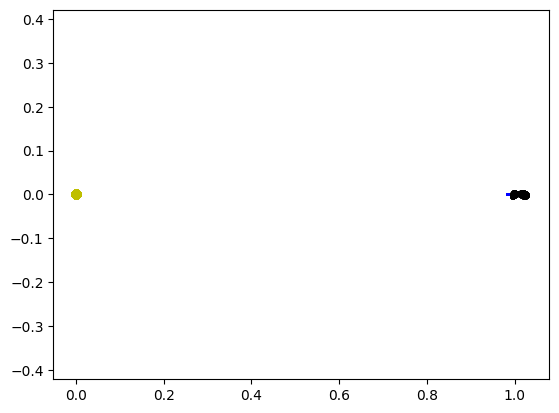

In [47]:
fig,axs = plt.subplots(1,1)
axs.plot(rearth_rot[:,0],rearth_rot[:,1],'bo',ms=1)
axs.plot(rsun_rot[:,0],rsun_rot[:,1],'yo')
axs.plot(rjwst_rot[:,0],rjwst_rot[:,1],'ko',ms=2)
axs.axis('equal')

**Haciendo la gráfica en 3d**

In [48]:
# Creando la figura con Plotly
fig = go.Figure()

# Agregando los trazos de las trayectrorias de los cuerpos en el sistema rotante 
fig.add_trace(go.Scatter3d(x=rearth_rot[:,0], y=rearth_rot[:,1], z=rearth_rot[:,2], mode='markers', name='Earth-Moon'))
fig.add_trace(go.Scatter3d(x=rsun_rot[:,0], y=rsun_rot[:,1], z=rsun_rot[:,2], mode='markers', name='Sun'))
fig.add_trace(go.Scatter3d(x=rjwst_rot[:,0], y=rjwst_rot[:,1], z=rjwst_rot[:,2], mode='lines', name='jwst'))

fig.update_layout(title="Trayectoria del wst en el sistema rotante", scene=dict(aspectmode='cube'))
fig.show()
fig.write_html("trayectorias_planetas.html")

**Calculemos la constante de Jacobi en el tiempo** 

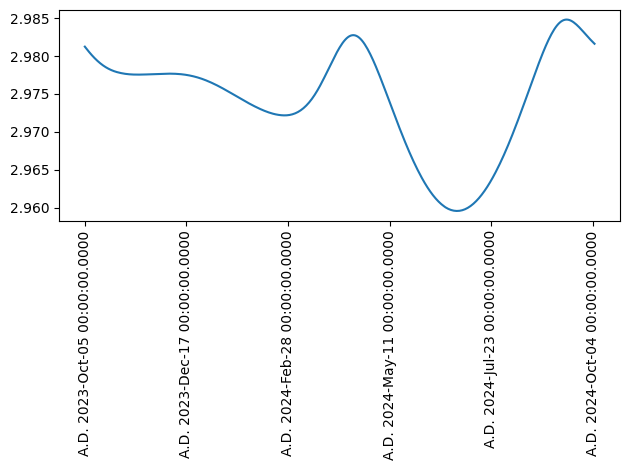

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Primero obtengamos r1 y r2
r1 = np.linalg.norm(rjwst - rsun, axis=1)
r2 = np.linalg.norm(rjwst - rearth, axis=1)

# Hallemos la magnitud de la velocidad en el sistema de rotacion del JWST
vjwst_rot_magnitude = np.linalg.norm(vjwst_rot, axis=1)

# Ahora para la constante de Jacobi
C_j = (2 * (mu1/r1 + mu2/r2) +
       omega**2 * (rjwst_rot[:, 0]**2 + rjwst_rot[:, 1]**2) -
       vjwst_rot_magnitude)

# Para visualizar
plt.plot(np.array(jwst['datetime_str']), C_j)

# Ajustes en el gráfico
locs, labels = plt.xticks()  # obtener ubicaciones y etiquetas actuales
plt.xticks(locs[::len(locs)//5], rotation=90)  # usar solo 6 etiquetas y rotar 90°

plt.tight_layout()  # para asegurarnos que las etiquetas no se corten
plt.show()


In [71]:
jwst['datetime_str']

0      A.D. 2023-Oct-05 00:00:00.0000
1      A.D. 2023-Oct-06 00:00:00.0000
2      A.D. 2023-Oct-07 00:00:00.0000
3      A.D. 2023-Oct-08 00:00:00.0000
4      A.D. 2023-Oct-09 00:00:00.0000
                    ...              
362    A.D. 2024-Oct-01 00:00:00.0000
363    A.D. 2024-Oct-02 00:00:00.0000
364    A.D. 2024-Oct-03 00:00:00.0000
365    A.D. 2024-Oct-04 00:00:00.0000
366    A.D. 2024-Oct-05 00:00:00.0000
Name: datetime_str, Length: 367, dtype: object

In [ ]:
# Definamos una función que obtenga la constante de Jacobi

def Jacobi_constant(mu1,mu2,r1,r2,w,rxy_rot,v):

    # Obteniendo las componentes x y y 
    x=rxy_rot[0]
    y=rxy_rot[1]

    C_j=2(mu1/r1+mu2/r2)+w**2(x**2+y**2)-v**2
    return C_j


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])